# 복습과제 1

## 데이터 작업하기

In [4]:
# Load torch

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다. (Use MNIST Data)
# Download FashionMNIST Dataset and transform to Tensor
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
# Download FashionMNIST Dataset and transform to Tensor
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Dataset 을 DataLoader 의 인자로 전달합니다. 이는 데이터셋을 순회 가능한 객체(iterable)로 감싸고, 자동화된 배치(batch), 샘플링(sampling), 섞기(shuffle) 및 다중 프로세스로 데이터 불러오기(multiprocess data loading)를 지원합니다. 여기서는 배치 크기(batch size)를 64로 정의합니다. 즉, 데이터로더(dataloader) 객체의 각 요소는 64개의 특징(feature)과 정답(label)을 묶음(batch)으로 반환합니다.

In [6]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## 모델 만들기

In [7]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.7.1+cu128
12.8
True


In [8]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #784개의 input -> 512개의 hidden layer 1
            nn.ReLU(),
            nn.Linear(512, 512), # 512 -> 512 hidden layer 2
            nn.ReLU(),
            nn.Linear(512, 10) # 512 -> 10 output
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 모델 매개변수 최적화

In [10]:
loss_fn = nn.CrossEntropyLoss() # cross-entropy loss 이용
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # sgd algorithm으로 최적화

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y) # loss 계산하는 부분

        # 역전파
        optimizer.zero_grad() # gradient를 0으로 초기화
        loss.backward() # 역전파로 계산하는 단계
        optimizer.step() # 최적화

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293261  [   64/60000]
loss: 2.286776  [ 6464/60000]
loss: 2.272684  [12864/60000]
loss: 2.274818  [19264/60000]
loss: 2.248167  [25664/60000]
loss: 2.232387  [32064/60000]
loss: 2.232615  [38464/60000]
loss: 2.202997  [44864/60000]
loss: 2.202333  [51264/60000]
loss: 2.188747  [57664/60000]
Test Error: 
 Accuracy: 51.9%, Avg loss: 2.170726 

Epoch 2
-------------------------------
loss: 2.170503  [   64/60000]
loss: 2.164058  [ 6464/60000]
loss: 2.113254  [12864/60000]
loss: 2.139286  [19264/60000]
loss: 2.075231  [25664/60000]
loss: 2.029515  [32064/60000]
loss: 2.053111  [38464/60000]
loss: 1.975955  [44864/60000]
loss: 1.981951  [51264/60000]
loss: 1.933792  [57664/60000]
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.912813 

Epoch 3
-------------------------------
loss: 1.932061  [   64/60000]
loss: 1.907706  [ 6464/60000]
loss: 1.792822  [12864/60000]
loss: 1.846908  [19264/60000]
loss: 1.730732  [25664/60000]
loss: 1.677718  [32064/600

## 모델 저장하기

In [14]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## 모델 불러오기

In [15]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## 예측하기

Predicted: Pullover, Actual: Coat


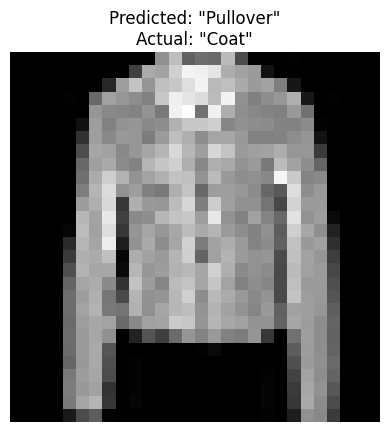

Predicted: Sandal, Actual: Sandal


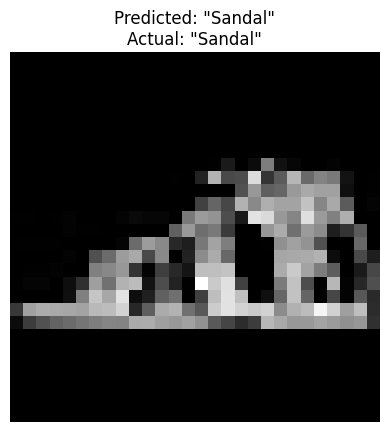

Predicted: Sneaker, Actual: Sneaker


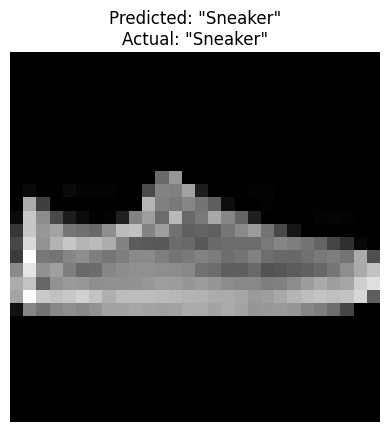

Predicted: Dress, Actual: Dress


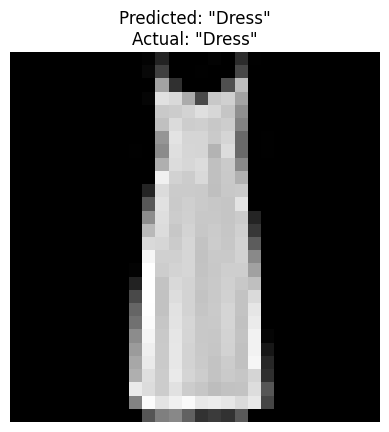

Predicted: Coat, Actual: Coat


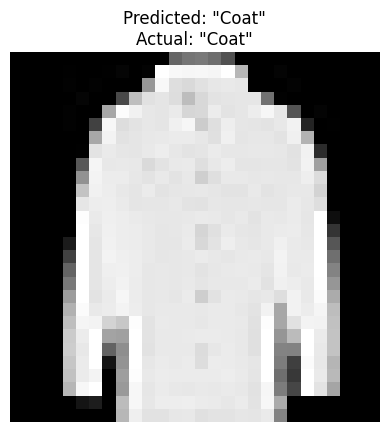

In [18]:
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
for i in range(10,15):
    x, y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        x = x.to(device)
        pred = model(x.unsqueeze(0))  # 배치 차원 추가
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f"Predicted: {predicted}, Actual: {actual}")
        # 이미지 출력
        plt.imshow(x.cpu().squeeze(), cmap='gray')
        plt.title(f'Predicted: "{predicted}"\nActual: "{actual}"')
        plt.axis('off')
        plt.show()

# 복습과제 2

### Q1) What is the number of total parameters in this MLP model? Why?

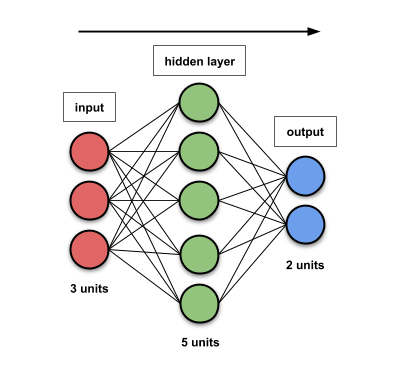

Your Answer: $3 \times 5 \text{(weight)} + 5\text{(bias)} + 5 \times 2\text{(weight)}  +2\text{(bias)} = 32$

### Q2) Using the Gradient Descent Algorithm, the loss of the model will decrease continuously to a specific point, which is a minimum. Is it the optimal point? Why or why not?

Your Answer: 비선형 신경망의 비볼록(non-convex) 구조 때문에 최적(global) 최소값이 아니라 local minimum이나 saddle point일 수 있음

### Q3) Is it possible to decrease the training error to zero? *(Hint: Think about the Universal Approximation Theorem)*

Your Answer: Universal Approximation Theorem에 따르면 충분히 큰 신경망은 어떤 연속적인 함수도 임의의 정확도(arbitrary accuracy)로 근사할 수 있으므로, 이론적으로는 학습오차를 0으로 만들 수 있으나, 실제로는 과적합, 데이터 노이즈, 최적화의 난이도 등의 현실적인 한계 때문에 완전히 0이 되기는 어려움

### Q4) Is deep learning the best method to build models? That is, does deeper networks generalize better than other methods? *(Hint: it is somehow related with question 3)*

Your Answer: 모델의 깊이가 무조건 일반화 성능을 보장하는 것이 아니며, 데이터의 특성과 크기에 따라 전통적인 머신러닝 방법이 더 효율적이고, 더 나은 일반화 성능을 제공하기도 함